<a href="https://colab.research.google.com/github/shreyasrajesh0308/NNDL-proj/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Paper: 

### Load Data 

Load preprocessed data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:

X_test = np.load("/content/drive/MyDrive/eeg_project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/eeg_project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/eeg_project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/eeg_project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/eeg_project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/eeg_project/person_test.npy")


In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [6]:
print(np.unique(y_train_valid))
print(np.unique(y_test))

[769 770 771 772]
[769 770 771 772]


In [7]:
num_classes = 4
y_train_valid = y_train_valid-769
y_test = y_test-769

In [8]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [9]:
def data_prep_test(X,y, sub_sample=2):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X,total_y


X_test,y_test = data_prep_test(X_test, y_test,2)


Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


In [10]:

y_train_valid_prep = keras.utils.to_categorical(y_train_valid_prep, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
print(X_train_valid_prep.shape,y_train_valid_prep.shape)
print(X_test.shape, y_test.shape)

(8460, 22, 250) (8460, 4)
(443, 22, 250) (443, 4)


### Indices for subject one training 

In [8]:
train_indeces = [ i for i in range(len(person_train_valid)) if person_train_valid[i]==0]
X_train_subject_1 = X_train_valid_prep[train_indeces]
y_train_subject_1 = y_train_valid_prep[train_indeces]

In [9]:
print(X_train_subject_1.shape, y_train_subject_1.shape)

(237, 22, 250) (237, 16)


### Indices for subject one testing 

In [ ]:
test_indeces = [ i for i in range(len(person_test)) if person_test[i]==0]
X_test_subject_1 = X_test[test_indeces]
y_test_subject_1 = y_test[test_indeces]

In [ ]:
print(X_train_subject_1.shape)
print(X_test_subject_1.shape)
print(y_train_subject_1.shape)
print(y_test_subject_1.shape)

(237, 22, 1000)
(50, 22, 1000)
(237, 4)
(50, 4)


In [ ]:
num_classes = len(np.unique(y_train_valid))

In [ ]:
X_train_subject_1 = np.swapaxes(X_train_subject_1, 1, 2)
X_test_subject_1 = np.swapaxes(X_test_subject_1, 1, 2)

In [ ]:
X_train_subject_1.shape

(237, 1000, 22)

In [ ]:
X_test_subject_1.shape

(50, 1000, 22)

In [ ]:
X_train_subject_1[0][0]

array([ 5.6640625 ,  9.47265625,  7.51953125,  7.76367188,  3.07617188,
        5.12695312,  3.75976562,  6.15234375,  3.36914062,  3.125     ,
       -1.41601562, -2.83203125, -5.078125  ,  2.24609375,  0.        ,
       -1.953125  , -3.85742188, -5.078125  , -3.22265625, -4.05273438,
       -6.15234375, -7.08007812])

In [ ]:
from sklearn.preprocessing import normalize
X_train_subject_1 = normalize(X_train_subject_1, axis=1, norm='l1')

ValueError: ignored

## Building a baseline with an GRU model with all channels, trained with one subject data

In [ ]:
print(X_train_subject_1.shape, y_train_subject_1.shape)

(237, 1000, 22) (237, 4)


In [ ]:
def create_model():
  model = keras.Sequential()
  model.add(
      keras.layers.Bidirectional(
        layers.GRU(512)
      )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(y_train_subject_1.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# model = KerasClassifier(build_fn=create_model, verbose=0)
# # define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [5,10]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train_subject_1, y_train_subject_1)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/us

AttributeError: ignored

In [ ]:
model = keras.Sequential()
initializer = keras.initializers.HeNormal()
model.add(keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
)
)
model.add(
    keras.layers.Bidirectional(
      layers.GRU(64)
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=4096, activation='relu'))
model.add(keras.layers.Dense(units=4096, activation='relu'))
model.add(keras.layers.Dense(y_train_valid.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(
    X_train_subject_1, y_train_subject_1,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
14/14 [==============================] - 6s 126ms/step - loss: 1.6701 - acc: 0.3239 - val_loss: 1.8804 - val_acc: 0.2500
Epoch 2/30
14/14 [==============================] - 1s 70ms/step - loss: 1.4630 - acc: 0.3286 - val_loss: 1.4542 - val_acc: 0.2083
Epoch 3/30
14/14 [==============================] - 1s 70ms/step - loss: 1.3438 - acc: 0.3474 - val_loss: 1.4926 - val_acc: 0.2500
Epoch 4/30
14/14 [==============================] - 1s 70ms/step - loss: 1.2597 - acc: 0.4272 - val_loss: 1.5507 - val_acc: 0.2500
Epoch 5/30
14/14 [==============================] - 1s 69ms/step - loss: 1.2592 - acc: 0.4225 - val_loss: 1.6579 - val_acc: 0.2083
Epoch 6/30
14/14 [==============================] - 1s 70ms/step - loss: 1.2447 - acc: 0.4178 - val_loss: 1.5537 - val_acc: 0.2083
Epoch 7/30
14/14 [==============================] - 1s 70ms/step - loss: 1.1911 - acc: 0.4507 - val_loss: 1.5920 - val_acc: 0.2083
Epoch 8/30
14/14 [==============================] - 1s 71ms/step - loss: 1.1288 - 

In [ ]:
model.summary()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_107 (Bidirect  (None, 128)              33792     
 ional)                                                          
                                                                 
 dropout_107 (Dropout)       (None, 128)               0         
                                                                 
 dense_224 (Dense)           (None, 4096)              528384    
                                                                 
 dense_225 (Dense)           (None, 4096)              16781312  
                                                                 
 dense_226 (Dense)           (None, 4)                 16388     
                                                                 
Total params: 17,359,876
Trainable params: 17,359,876
Non-trainable params: 0
________________________________________

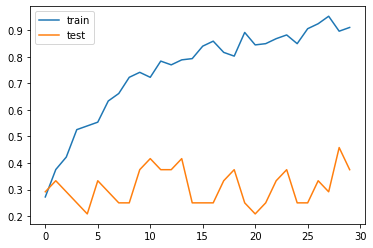

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [ ]:
model.evaluate(X_test_subject_1, y_test_subject_1)

2/2 [==============================] - 0s 50ms/step - loss: 2.2870 - acc: 0.3400


[2.2870020866394043, 0.3400000035762787]

In [ ]:

accuracies = []
for drop in [0,0.1,0.2,0.4,0.5,0.7]:
  for batch in [8,16,32,64,128]:
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
          layers.GRU(8)
        )
    )
    model.add(keras.layers.Dropout(rate=drop))
    model.add(keras.layers.Dense(units=2048, activation='relu'))
    model.add(keras.layers.Dense(y_train_subject_1.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    history = model.fit(
      X_train_subject_1, y_train_subject_1,
      epochs=20,
      batch_size=batch,
      validation_split=0.1,
      shuffle=False
    )
    accuracies.append(np.array([history.history['val_acc'][-1], drop, batch]))





Epoch 1/20
27/27 [==============================] - 5s 71ms/step - loss: 1.4136 - acc: 0.2582 - val_loss: 1.4191 - val_acc: 0.2917
Epoch 2/20
27/27 [==============================] - 1s 45ms/step - loss: 1.2499 - acc: 0.4413 - val_loss: 1.4505 - val_acc: 0.2917
Epoch 3/20
17/27 [=================>............] - ETA: 0s - loss: 1.1311 - acc: 0.5515

KeyboardInterrupt: ignored

In [ ]:
accuracies - np.array(accuracies)
best_drop = accuracies[np.argmax(accuracies[:,0]),1]
best_batch = accuracies[np.argmax(accuracies[:,0]),2]
accuracies - np.array(accuracies)
print("Best validation accuracy", np.max(accuracies[:,0]), "with Dropout Rate",
      best_drop, "and batch size", best_batch)

Best validation accuracy 0.375 with Dropout Rate 0.5 and batch size 64.0


In [ ]:
accuracies = np.array(accuracies)
accuracies[np.argmax(accuracies[:,0]),1]

0.5

In [ ]:
print(accuracies)

[[3.7837493419647217, 0, 8], [3.2250747680664062, 0, 16], [3.2023017406463623, 0, 32], [3.0361130237579346, 0, 64], [3.1093151569366455, 0, 128], [5.271199703216553, 0.1, 8], [3.720784902572632, 0.1, 16], [3.4172661304473877, 0.1, 32], [3.1512153148651123, 0.1, 64], [3.2362709045410156, 0.1, 128], [4.4613800048828125, 0.2, 8], [3.5623245239257812, 0.2, 16], [3.413505792617798, 0.2, 32], [3.407851457595825, 0.2, 64], [3.1940925121307373, 0.2, 128], [4.846121788024902, 0.4, 8], [4.416743755340576, 0.4, 16], [3.9036808013916016, 0.4, 32], [3.706195831298828, 0.4, 64], [3.215125799179077, 0.4, 128], [5.031581878662109, 0.5, 8], [4.087917804718018, 0.5, 16], [4.490284442901611, 0.5, 32], [3.9504497051239014, 0.5, 64], [3.636662244796753, 0.5, 128], [4.16558837890625, 0.7, 8], [3.8689358234405518, 0.7, 16], [3.397963285446167, 0.7, 32], [3.514254331588745, 0.7, 64], [3.5038821697235107, 0.7, 128]]


## GRU model with all subjects

In [16]:
model = keras.Sequential()
# initializer = keras.initializers.HeNormal()
# model.add(keras.layers.BatchNormalization(
#     axis=-1,
#     momentum=0.99,
#     epsilon=0.001,
#     center=True,
#     scale=True,
#     beta_initializer="zeros",
#     gamma_initializer="ones",
#     moving_mean_initializer="zeros",
#     moving_variance_initializer="ones",
#     beta_regularizer=None,
#     gamma_regularizer=None,
#     beta_constraint=None,
#     gamma_constraint=None
# ))
model.add(keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
)
)
model.add(
    keras.layers.Bidirectional(
      layers.GRU(16)
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=10, activation='relu'))
model.add(keras.layers.Dense(y_train_valid_prep.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [17]:
history = model.fit(
    X_train_valid_prep, y_train_valid_prep,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
476/476 [==============================] - 12s 16ms/step - loss: 1.4031 - acc: 0.3186 - val_loss: 1.2879 - val_acc: 0.4149
Epoch 2/30
476/476 [==============================] - 6s 13ms/step - loss: 1.2763 - acc: 0.4098 - val_loss: 1.1997 - val_acc: 0.4953
Epoch 3/30
476/476 [==============================] - 6s 13ms/step - loss: 1.1882 - acc: 0.4651 - val_loss: 1.1311 - val_acc: 0.5213
Epoch 4/30
476/476 [==============================] - 6s 13ms/step - loss: 1.1283 - acc: 0.5106 - val_loss: 1.0662 - val_acc: 0.5544
Epoch 5/30
476/476 [==============================] - 6s 13ms/step - loss: 1.0591 - acc: 0.5517 - val_loss: 1.0146 - val_acc: 0.5827
Epoch 6/30
476/476 [==============================] - 6s 13ms/step - loss: 1.0088 - acc: 0.5783 - val_loss: 0.9496 - val_acc: 0.6158
Epoch 7/30
476/476 [==============================] - 6s 13ms/step - loss: 0.9472 - acc: 0.6060 - val_loss: 0.9214 - val_acc: 0.6371
Epoch 8/30
476/476 [==============================] - 6s 13ms/step -

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 22, 250)          1000      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               25728     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 27,102
Trainable params: 26,602
Non-trai

In [19]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 7ms/step - loss: 2.3236 - acc: 0.3589


[2.323568820953369, 0.3589164912700653]

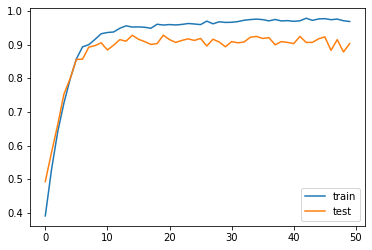

In [27]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();